In [1]:
import torch
import numpy
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [2]:
# create datasets
n_dim = 2 # feature의 수
# x_train : 좌표, y_train : 어느 영역에 속하는지 정보(0, 1, 2, 3)
x_train, y_train = make_blobs(n_samples=80, n_features=n_dim,
                              centers=[[1, 1], [-1, -1], [1, -1], [-1, 1]],
                              shuffle=True, cluster_std=0.3)
x_test, y_test = make_blobs(n_samples=20, n_features=n_dim,
                            centers=[[1, 1], [-1, -1], [1, -1], [-1, 1]],
                            shuffle=True, cluster_std=0.3)

In [3]:
# 0, 1 -> 0 / 2, 3 -> 1
# 두 가지만 예측할 수 있는 간단한 모델로 수정(Binary classification)
# BCELoss를 사용
def label_map(y_, from_, to_):
    y = numpy.copy(y_)
    for f in from_:
        y[y_ == f] = to_
    return y

y_train = label_map(y_train, [0, 1], 0)
y_train = label_map(y_train, [2, 3], 1)
y_test = label_map(y_test, [0, 1], 0)
y_test = label_map(y_test, [2, 3], 1)

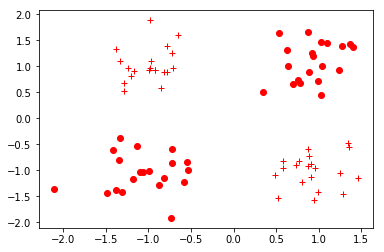

In [4]:
# 데이터 분포 확인
# (x, y) -> data, {0, 1, 2, 3} -> label
def vis_data(x, y = None, c = 'r'):
    if y is None:
        y = [None] * len(y)
    for x_, y_ in zip(x, y):
        if y_ is None:
            plt.plot(x_[0], x_[1], '*', markerfacecolor = 'none',
                     markeredgecolor = c)
        else:
            plt.plot(x_[0], x_[1], c+'o' if y_ == 0 else c+'+')
 
plt.figure()
vis_data(x_train, y_train)
plt.show()

In [6]:
# 학습을 위해 텐서에 해당 정보를 넣는다.
x_train = torch.FloatTensor(x_train)
x_test = torch.FloatTensor(x_test)
y_train = torch.FloatTensor(y_train)
y_test = torch.FloatTensor(y_test)

In [8]:
# 신경망 모델 구현
class NeuralNet(torch.nn.Module):
    def __init__(self, input_size, hidden_size):
        super(NeuralNet, self).__init__() # nn.Module 초기화
        # input_size : 입력 데이터의 차원
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        # 신경망을 거치는 연산 정의
        self.linear_1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.relu = torch.nn.ReLU()
        self.linear_2 = torch.nn.Linear(self.hidden_size, 1)
        self.sigmoid = torch.nn.Sigmoid()
    
    # 학습 진행을 표현한 함수
    # 학습 진행할 때 자동으로 실행된다.
    def forward(self, input_tensor):
        linear1 = self.linear_1(input_tensor)
        relu = self.relu(linear1)
        linear2 = self.linear_2(relu)
        output = self.sigmoid(linear2)
        return output

In [9]:
# 신경망 객체 생성, 학습률, 오차 함수, epoch, 최적화 함수 설정
model = NeuralNet(2, 5)
learning_rate = 0.03
criterion = torch.nn.BCELoss()
epochs = 2000
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

In [10]:
# 학습 이전의 모델 성능 평가
model.eval()
test_loss_before = criterion(model(x_test).squeeze(), y_test)
print('Before training, test loss is {}'.format(test_loss_before.item()))

Before training, test loss is 0.7263379693031311


In [11]:
# 학습
for epoch in range(epochs):
    model.train() # forward()함수 자동 호출
    optimizer.zero_grad() # 학습마다 새로운 경사값 갱신
    
    train_output = model(x_train)
    train_loss = criterion(train_output.squeeze(), y_train)
    
    if epoch % 100 == 0:
        print('Train loss at {} is {}'.format(epoch, train_loss.item()))
        
    # Backpropagation    
    train_loss.backward()
    optimizer.step()

Train loss at 0 is 0.7462173700332642
Train loss at 100 is 0.6774662733078003
Train loss at 200 is 0.6377118229866028
Train loss at 300 is 0.5950856804847717
Train loss at 400 is 0.5310377478599548
Train loss at 500 is 0.44386690855026245
Train loss at 600 is 0.358023464679718
Train loss at 700 is 0.28529849648475647
Train loss at 800 is 0.2275383174419403
Train loss at 900 is 0.18309877812862396
Train loss at 1000 is 0.1492544710636139
Train loss at 1100 is 0.12350460141897202
Train loss at 1200 is 0.10388760268688202
Train loss at 1300 is 0.08868918567895889
Train loss at 1400 is 0.07674073427915573
Train loss at 1500 is 0.0671815276145935
Train loss at 1600 is 0.05942470580339432
Train loss at 1700 is 0.053072065114974976
Train loss at 1800 is 0.04778430983424187
Train loss at 1900 is 0.043319568037986755


In [12]:
model.eval()
test_loss_before = criterion(torch.squeeze(model(x_test)), y_test)
print('After training, test loss is {}'.format(test_loss_before.item()))

After training, test loss is 0.06870509684085846


In [13]:
# save the mode
torch.save(model.state_dict(), './model.pt')
print('state_dict format of the model: {}'.format(model.state_dict()))

state_dict format of the model: OrderedDict([('linear_1.weight', tensor([[-1.8323,  1.8478],
        [-0.6920, -0.0156],
        [ 1.8519, -1.4874],
        [ 0.1995,  0.4969],
        [ 0.9331,  0.9331]])), ('linear_1.bias', tensor([-0.5335,  1.3182, -0.2653, -0.3909,  0.0284])), ('linear_2.weight', tensor([[ 2.6237, -1.3637,  2.3283, -0.2227, -1.2206]])), ('linear_2.bias', tensor([-1.4508]))])


In [14]:
# 저장된 모델 활용
new_model = NeuralNet(2, 5)
new_model.load_state_dict(torch.load('./model.pt'))

new_model.eval()
print('벡터 [-1, 1]이 레이블 1을 가질 확률은 {}'.format(new_model(torch.FloatTensor([-1, 1])).item()))

벡터 [-1, 1]이 레이블 1을 가질 확률은 0.9828837513923645
